# Project 2 - Generalized Linear Models with Newton's Methods

## Yan Bo Zeng

This project has been uploaded on GitHub: https://github.com/uclayanbo/OptimizationProjects/blob/main/Project%202%20-%20Generalized%20Linear%20Models%20with%20Quasi-Newton%20Methods.ipynb

In [18]:
library(dplyr)
library(repr)
options(repr.plot.width = 12, repr.plot.height = 10)
options(scipen = 999)

# 1. Ordinary Least Squares

Recall the ordinary least squares model $y_i = x_i'\beta + \epsilon_i$. The maximum likelihood estimator (MLE) for the coefficient parameter $\beta$ is
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} -\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 \\
    & = \arg\min_{\beta \in \mathbb{R}^k} \frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2
\end{align*}

Denote $\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 = Q(\beta)$, $X$ as the model matrix including the intercept term, and $Y$ as the outcome vector. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)x_i \\
    & = -\frac{1}{n} X'\left(Y - X\beta \right)
\end{align*}

The Hessian is
\begin{align*}
    \nabla^2 Q(\beta) & = \frac{1}{n} X'X \\
    & \succeq 0
\end{align*}

In [19]:
#Define the cost, gradient, and Hessian functions for OLS.
OLS_cost <- function(X, y, beta) {
    return(mean((y - X %*% beta)^2) / 2)
}

OLS_gradient <- function(X, y, beta) {
    return(-t(X) %*% (y - X %*% beta) / length(y))
}

OLS_hessian <- function(X, y, beta) {
    return(t(X) %*% X / length(y))
}

### Gradient Descent
Given a learning rate $\alpha_t$, gradient descent will iterate on
\begin{align*}
    \hat{\beta}_{t+1} & = \hat{\beta}_{t} - \alpha_t \nabla Q(\hat{\beta}_{t}) \\
    & = \hat{\beta}_{t} + \alpha_t \frac{1}{n} X'\left(Y - X\hat{\beta}_{t} \right)
\end{align*}

In [20]:
#Define the gradient descent function.
gradient_descent <- function(X, y, beta_init = rep(0, ncol(X)), num_iters = 200, alpha = 0.1,
                             error_func = OLS_cost, grad_func = OLS_gradient, linesearch = FALSE, linesearch_c = 0.8) {
    
    #Record errors (cost values) from each iteration.
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Record alpha for line search.
    alpha_init <- alpha
    
    #Implement gradient descent.
    for (i in 1:num_iters) {
        error_old <- error_func(X, y, beta)
        delta <- grad_func(X, y, beta)
        beta <- beta - alpha * delta
        
        #Implement backtracking line search.
        if (linesearch == TRUE) {
            while (error_func(X, y, beta) > (error_old - linesearch_c*alpha*(norm(delta)^2))) {
                error_old <- error_func(X, y, beta)
                alpha = alpha / 2
                delta <- grad_func(X, y, beta)
                beta <- beta - alpha * delta
            }
            alpha <- alpha_init
        }
        
        error_history[i] <- error_func(X, y, beta)
    }
    
    #Return the history for plotting.
    return(list(beta, error_history))
}

### Newton's Method
The Newton's method will iterate on
\begin{align*}
    \hat{\beta}_{t+1} & = \hat{\beta}_{t} - \left(\nabla^2 Q(\hat{\beta}_{t}) \right)^{-1} \nabla Q(\hat{\beta}_{t})
\end{align*}

In [21]:
#Define the Newton's method function.
newton_method <- function(X, y, beta_init = rep(0, ncol(X)), num_iters = 200,
                          error_func = OLS_cost, grad_func = OLS_gradient, hessian_func = OLS_hessian) {
    
    #Record errors (cost values) from each iteration.
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Implement Newton's method.
    for (i in 1:num_iters) {
        delta <- solve(hessian_func(X, y, beta)) %*% grad_func(X, y, beta)
        beta <- beta - delta
        error_history[i] <- error_func(X, y, beta)
    }
    
    #Return the history for plotting.
    return(list(beta, error_history))
}

### BFGS

In [22]:
#Define the BFGS function.
bfgs <- function(X, y, beta_init = rep(0, ncol(X)), num_iters = 200, alpha = 0.1, linesearch_c = 0.8,
                 error_func = OLS_cost, grad_func = OLS_gradient) {
    
    #Record errors (cost values) from each iteration.
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Record alpha for line search.
    alpha_init <- alpha
    
    #Initialize the inverse Hessian approximation with identity.
    n <- ncol(X)
    H <- diag(n)
    
    #Implement BFGS.
    for (i in 1:num_iters) {
        delta <- H %*% grad_func(X, y, beta)
        beta_new <- beta - alpha * delta
        
        #Implement backtracking line search.
        while (error_func(X, y, beta_new) >
               (error_func(X, y, beta) - linesearch_c * alpha * (t(grad_func(X, y, beta)) %*% delta))) {
            alpha = alpha / 2
        }
        
        sk <- beta_new - beta
        yk <- grad_func(X, y, beta_new) - grad_func(X, y, beta)
        
        #Sherman-Morrison-Woodbury.
        rho <- c(1 / (t(yk) %*% sk))
        
        #Update the inverse Hessian approximation.
        H <- (diag(n) - rho * sk %*% t(yk)) %*% H %*% (diag(n) - rho * yk %*% t(sk)) + rho * sk %*% t(sk)
        
        #Update beta and reset alpha.
        beta <- beta_new
        alpha <- alpha_init
        error_history[i] <- error_func(X, y, beta)
    }
    
    #Return the history for plotting.
    return(list(beta, error_history))
}

## Test the algorithm on orange juice advertisement data.
Firstly, we can use the R built-in glm() package to obtain a robust estimate of the coefficients.

In [24]:
oj <- read.csv("C:/Users/yanbo/OneDrive/Stanford MS&E 311 Optimization/oj.csv")
X <- model.matrix(log(sales) ~ log(price) + brand, data = oj)
y <- log(oj$sales)

builtin <- glm(log(sales) ~ log(price) + brand, data = oj)
coef(builtin) %>% as.matrix()

(Intercept),10.8288216
log(price),-3.1386914
brandminute.maid,0.8701747
brandtropicana,1.5299428


In [25]:
betalist_gd2_ls <- gradient_descent(X, y, alpha = 2, linesearch = TRUE)
betalist_gd01_ls <- gradient_descent(X, y, linesearch = TRUE)
betalist_newton <- newton_method(X, y)
betalist_bfgs <- bfgs(X, y)

display <- cbind(betalist_gd2_ls[[1]], betalist_gd01_ls[[1]], betalist_newton[[1]], betalist_bfgs[[1]])
colnames(display) <- c("GD, line search, alpha = 2", "GD, line search, alpha = 0.1", "Newton's", "BFGS, alpha = 0.1")
display

,"GD, line search, alpha = 2","GD, line search, alpha = 0.1",Newton's,"BFGS, alpha = 0.1"
(Intercept),10.8288216,9.7142440,10.8288216,10.8288217
log(price),-3.1386914,-1.0204047,-3.1386914,-3.1386915
brandminute.maid,0.8701746,0.2811513,0.8701747,0.8701745
brandtropicana,1.5299428,0.3799773,1.5299428,1.5299427


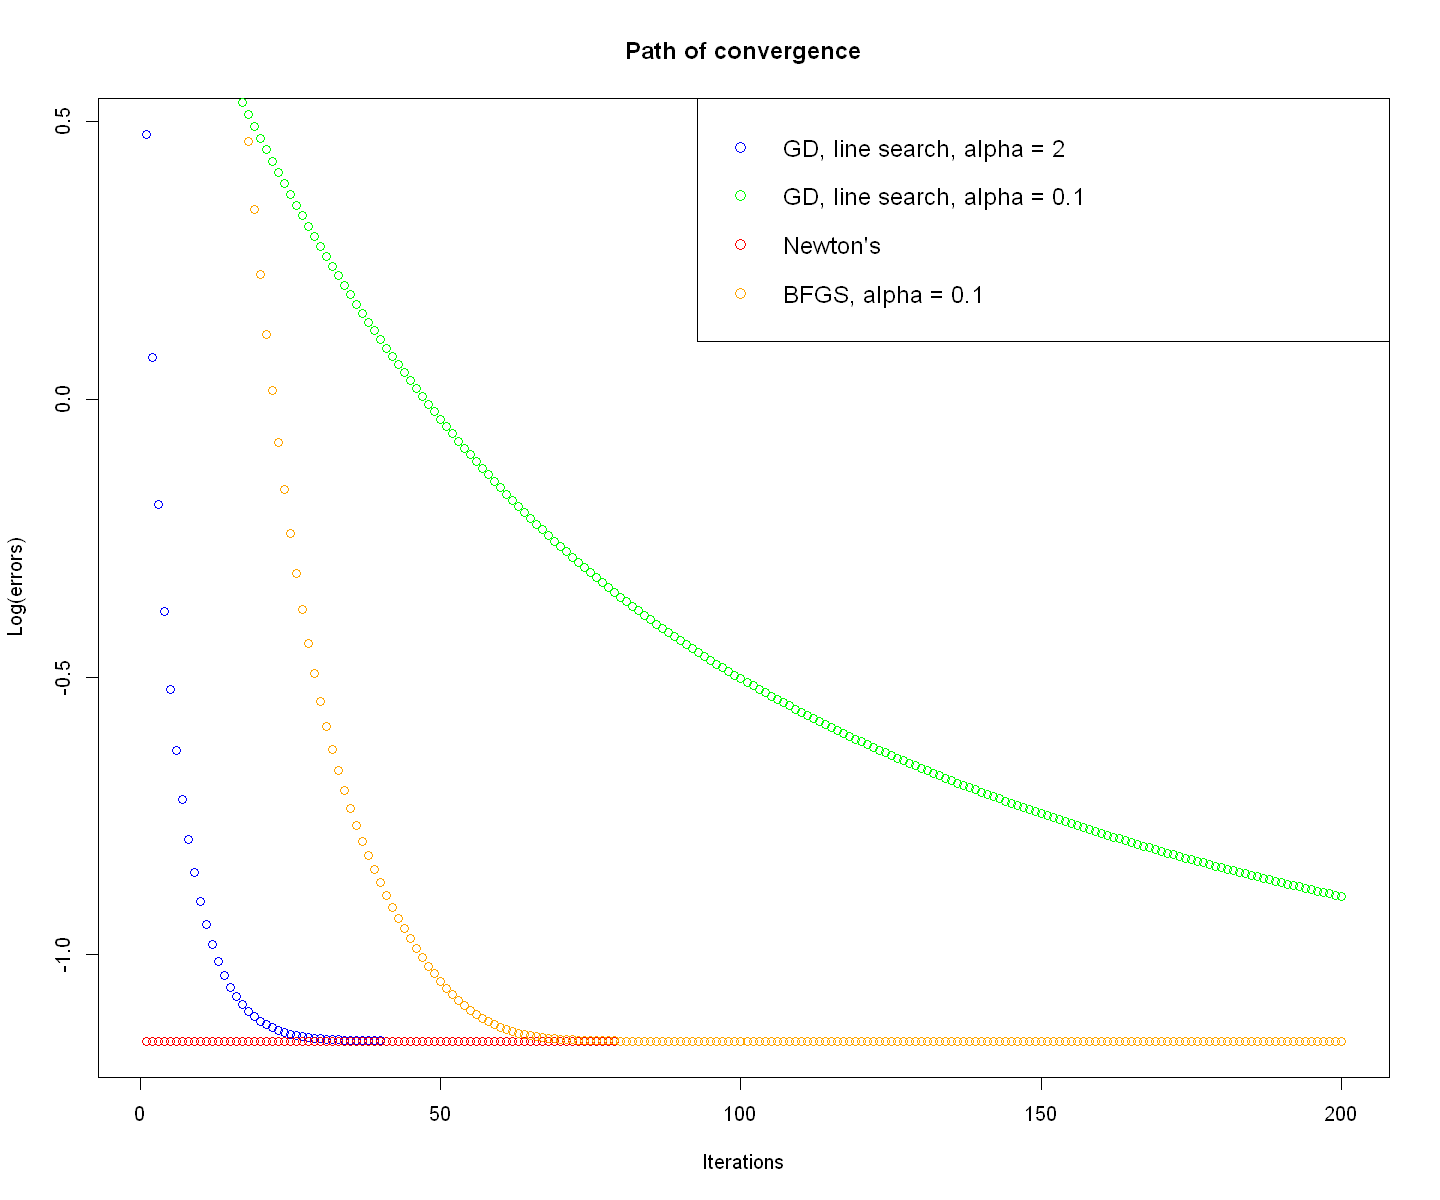

In [26]:
#Visualize the path of convergence.
plot(log(betalist_gd2_ls[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist_gd01_ls[[2]]), col = 'green')
points(log(betalist_newton[[2]]), col = 'red')
points(log(betalist_bfgs[[2]]), col = 'orange')
legend("topright", legend = c("GD, line search, alpha = 2", "GD, line search, alpha = 0.1", "Newton's", "BFGS, alpha = 0.1"),
       col = c("blue", "green", "red", "orange"), bty = "o", pch = 1, cex = 1.2)

Here, using a learning rate of $0.01$ results in slow convergence, and therefore $\hat{\beta}$ cannot converge to the "correct" values within $20,000$ iterations. While learning rates of $0.1$ and $0.4$ perform very well, a learning rate of $2$ is too large, causing the algorithm to diverge and return NAs for all coefficients. On the other hand, the orange curve shows that line search is really helpful in finding a decent $\alpha_t$ for fast convergence and preventing the algorithm from blowing up.



For the OLS case, where $\hat{\beta} = \arg{\min\limits_\beta{\sum\limits_{i=1}^n{(y_i - x_i'\beta)^2}}}$, and $\sum\limits_{i=1}^n{x_ix_i'}$ is invertible, we have $\forall \beta \in \mathbb{R}$,

\begin{align*}
    \hat{Q}_n(\beta) & = \sum\limits_{i=1}^n{(y_i - x_i'\beta)^2} \\
    \frac{\partial \hat{Q}_n(\beta)}{\partial\beta} & = \sum\limits_{i=1}^n{2x_i(y_i - x_i'\beta)} = \sum\limits_{i=1}^n{2x_iy_i - 2x_ix_i'\beta} \\
    \frac{\partial^2 \hat{Q}_n(\beta)}{\partial\beta \partial\beta'} & = \sum\limits_{i=1}^n{-2x_ix_i'}
\end{align*}

Then, in just one iteration, the Newton's method will return the OLS solution:
\begin{align*}
    \hat{\beta} & = \beta - \left(\frac{\partial^2 \hat{Q}_n(\beta)}{\partial\beta \partial\beta'}\right)^{-1} \times \frac{\partial \hat{Q}_n(\beta)}{\partial\beta} \\
    & = \beta + \left(2\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \times 2\left(\sum\limits_{i=1}^n{x_iy_i} - \beta\sum\limits_{i=1}^n{x_ix_i'}\right) \\
    & = \beta - \left(2\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(2\beta\sum\limits_{i=1}^n{x_ix_i'}\right) + \left(2\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(2\sum\limits_{i=1}^n{x_iy_i}\right) \\
    & = \beta - \beta + \left(\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(\sum\limits_{i=1}^n{x_iy_i}\right) \\
    & = \left(\sum\limits_{i=1}^n{x_ix_i'}\right)^{-1} \left(\sum\limits_{i=1}^n{x_iy_i}\right)
\end{align*}

# 2. Logistic and Probit Regressions

Recall that in logit and probit models, $\hat{\beta}$ is obtained by maximizing the log-likelihood function or equivalently minimizing the cross-entropy loss function.
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\log{\left( \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \right)} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right)
\end{align*}

Denote $-\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right) = Q(\beta)$. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i}{F(x_i'\beta)} - \frac{1-y_i}{1-F(x_i'\beta)} \right) f(x_i'\beta)x_i \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \frac{y_i-F(x_i'\beta)}{F(x_i'\beta) \left(1-F(x_i'\beta) \right)} f(x_i'\beta)x_i
\end{align*}

The Hessian is
\begin{align*}
    \nabla^2 Q(\beta) & = -\frac{1}{n} \sum_{i=1}^{n} \frac{f(x_i'\beta)^2}{F(x_i'\beta) \left(1-F(x_i'\beta) \right)} x_i x_i'
\end{align*}

For logit, $F(x_i'\beta) = \frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}}$, and $f(x_i'\beta) = \left(\frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}} \right) \left(1 - \frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}} \right) = F(x_i'\beta) \left(1-F(x_i'\beta)\right)$.

For probit, $F(x_i'\beta) = \Phi(x_i'\beta)$, and $f(x_i'\beta) = \phi(x_i'\beta)$, where $\Phi(\cdot)$ and $\phi(\cdot)$ are the standard normal CDF and PDF, respectively.

In [29]:
#Define the cost and gradient functions for logit.
logit_cost <- function(X, y, beta) {
    return(-mean(y*log(exp(X%*%beta)/(1+exp(X%*%beta))) + (1-y)*log(1-exp(X%*%beta)/(1+exp(X%*%beta)))))
}

logit_gradient <- function(X, y, beta) {
    return(-t(X) %*% (y - exp(X%*%beta)/(1 + exp(X%*%beta))) / length(y))
}

logit_hessian <- function(X, y, beta) {
    H_hat <- matrix(0, nrow = ncol(X), ncol = ncol(X))
    for (i in 1:length(y)) {
        H_hat <- H_hat + -X[i, ] %*% t(X[i, ]) *
            as.numeric((1/(1+exp(-t(X[i, ])%*%beta))) * (1-(1/(1+exp(-t(X[i, ])%*%beta)))))
    }
    return(H_hat / length(y))
}

## Test the algorithm for logit on synthetic data.

In [30]:
set.seed(888)
n <- 10000
y <- runif(n) > 0.4
X <- cbind(Intercept = rep(1, n), x1 = rnorm(n, 0, 2), x2 = runif(n, -2, 1), x3 = rnorm(n, 4, 1), x4 = rnorm(n, -3, 5))
data <- data.frame(y, X)

builtin <- glm(y ~ x1 + x2 + x3 + x4, data = data, family = binomial(link = "logit"))
coef(builtin) %>% as.matrix()

(Intercept),0.4161762124
x1,0.0090180079
x2,-0.0318122563
x3,-0.0014710907
x4,0.0008547123


In [31]:
betalist_gd08_ls <- gradient_descent(X, y, alpha = 0.8, linesearch = TRUE, num_iters = 300,
                                     error_func = logit_cost, grad_func = logit_gradient)
betalist_gd01_ls <- gradient_descent(X, y, linesearch = TRUE, num_iters = 300,
                                     error_func = logit_cost, grad_func = logit_gradient)
betalist_bfgs <- bfgs(X, y, error_func = logit_cost, grad_func = logit_gradient, num_iters = 300)

display <- cbind(betalist_gd08_ls[[1]], betalist_gd01_ls[[1]], betalist_bfgs[[1]])
colnames(display) <- c("GD, line search, alpha = 0.8", "GD, line search, alpha = 0.1", "BFGS, alpha = 0.1")
display

,"GD, line search, alpha = 0.8","GD, line search, alpha = 0.1","BFGS, alpha = 0.1"
Intercept,0.4152896477,0.2322796413,0.4161762124
x1,0.0090203362,0.0095064768,0.0090180079
x2,-0.0318481777,-0.0392917096,-0.0318122563
x3,-0.0012704475,0.0401856108,-0.0014710907
x4,0.0008488198,-0.0003678496,0.0008547123


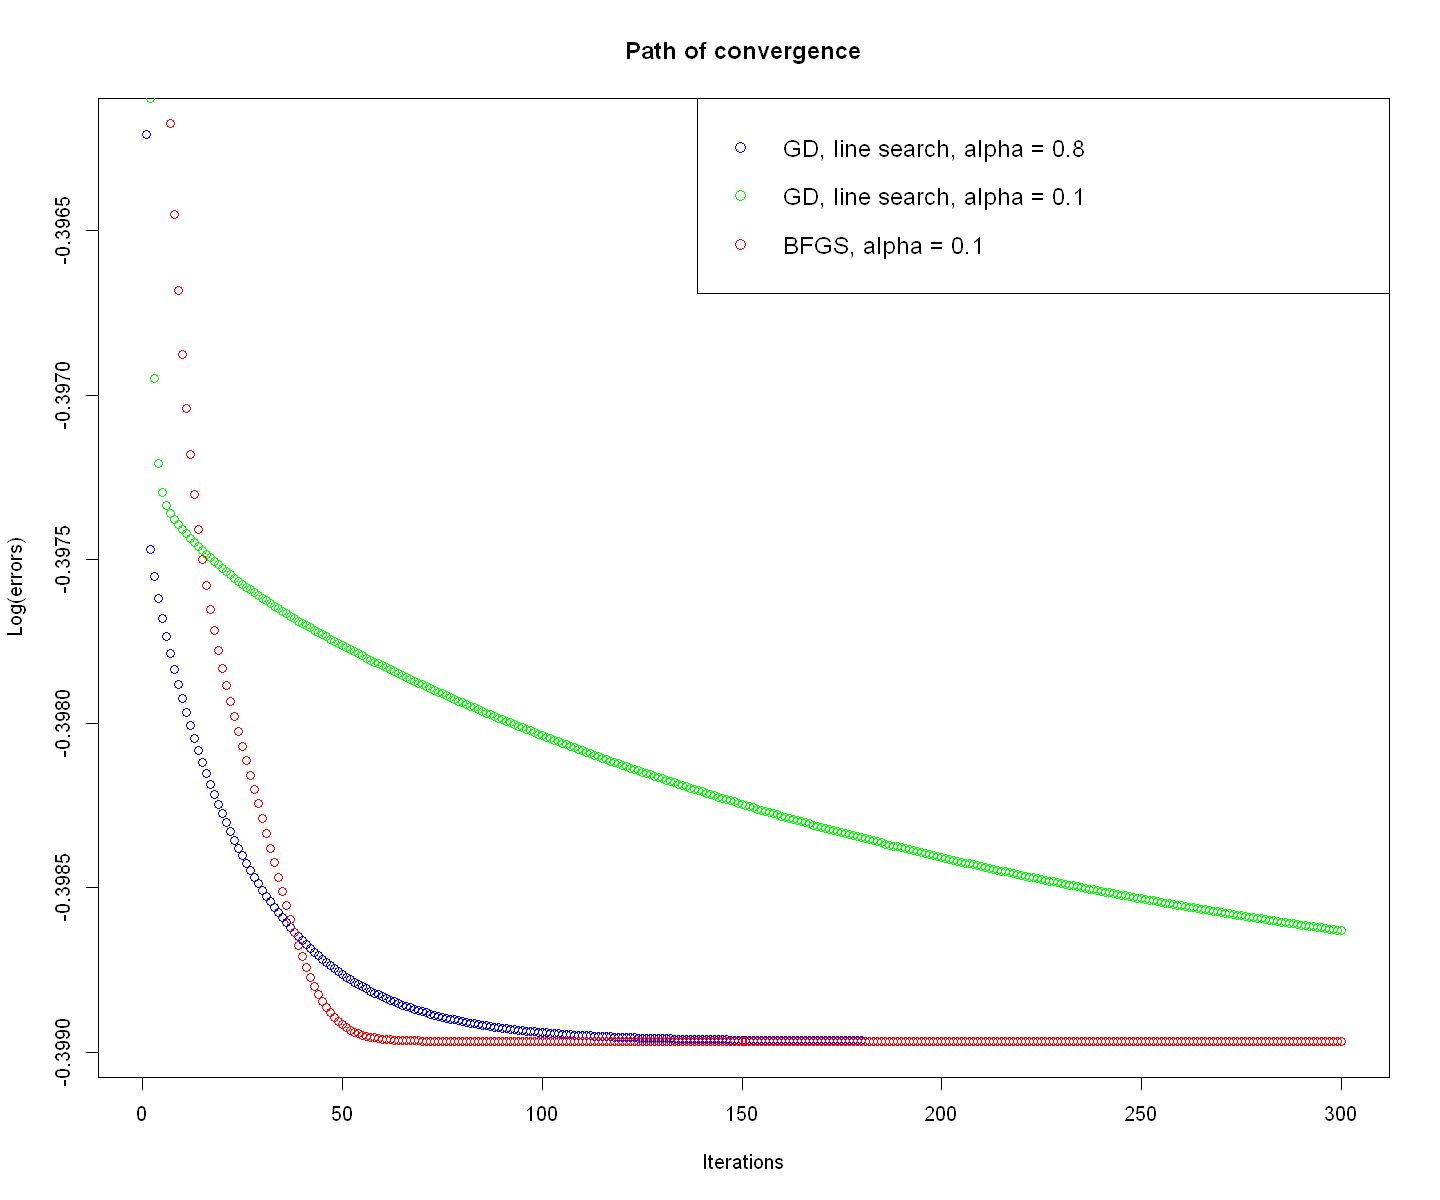

In [32]:
#Visualize the path of convergence.
plot(log(betalist_gd08_ls[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist_gd01_ls[[2]]), col = 'green')
points(log(betalist_bfgs[[2]]), col = 'red')
legend("topright", legend = c("GD, line search, alpha = 0.8", "GD, line search, alpha = 0.1", "BFGS, alpha = 0.1"),
       col = c("blue", "green", "red"), bty = "o", pch = 1, cex = 1.2)

In the logistic regression case, gradient descent converges slowly when using a learning rate of $0.01$, although we can see that it is on the right track. The algorithm diverges when the learning rate is $0.4$, and it begins bouncing around if we further increase the learning rate to $0.8$. After trying out different rates, we find that $\alpha_t = 0.1$ works the best. However, if we include the time for testing various $\alpha_t$'s, line search with an initial $\alpha_t = 0.8$ takes the least amount of time to obtain the correct estimates.

## Test the algorithm for probit.

In [33]:
#Define the cost and gradient functions for probit.
probit_cost <- function(X, y, beta) {
    return(-mean(y*log(pnorm(X%*%beta)) + (1-y)*log(1-pnorm(X%*%beta))))
}

probit_gradient <- function(X, y, beta) {
    return(-t(X) %*% ((y-pnorm(X%*%beta))/(pnorm(X%*%beta)*(1-pnorm(X%*%beta)))*dnorm(X%*%beta)) / length(y))
}

probit_hessian <- function(X, y, beta) {
    H_hat <- matrix(0, nrow = ncol(X), ncol = ncol(X))
    for (i in 1:length(y)) {
        H_hat <- H_hat + -X[i, ] %*% t(X[i, ]) *
            as.numeric((dnorm(t(X[i, ])%*%beta)^2) / (pnorm(t(X[i, ])%*%beta) * (1-pnorm(t(X[i, ])%*%beta))))
    }
    return(H_hat / length(y))
}

In [35]:
builtin <- glm(y ~ x1 + x2 + x3 + x4, data = data, family = binomial(link = "probit"))
coef(builtin) %>% as.matrix()

(Intercept),0.2599022393
x1,0.0055922210
x2,-0.0197340040
x3,-0.0008900177
x4,0.0005318751


In [36]:
betalist_gd01_ls <- gradient_descent(X, y, linesearch = TRUE, num_iters = 10^3,
                                     error_func = probit_cost, grad_func = probit_gradient)
betalist_gd001_ls <- gradient_descent(X, y, alpha = 0.01, linesearch = TRUE, num_iters = 10^3,
                                      error_func = probit_cost, grad_func = probit_gradient)
betalist_bfgs <- bfgs(X, y, error_func = probit_cost, grad_func = probit_gradient, alpha = 0.01, num_iters = 10^3)

display <- cbind(betalist_gd01_ls[[1]], betalist_gd001_ls[[1]], betalist_bfgs[[1]])
colnames(display) <- c("GD, line search, alpha = 0.1", "GD, line search, alpha = 0.01", "BFGS, alpha = 0.01")
display

,"GD, line search, alpha = 0.1","GD, line search, alpha = 0.01","BFGS, alpha = 0.01"
Intercept,0.2595557292,0.1322193500,0.2598865271
x1,0.0055931732,0.0059448993,0.0055920012
x2,-0.0197481606,-0.0249563420,-0.0197333612
x3,-0.0008116104,0.0280140755,-0.0008885584
x4,0.0005295621,-0.0003202064,0.0005316788


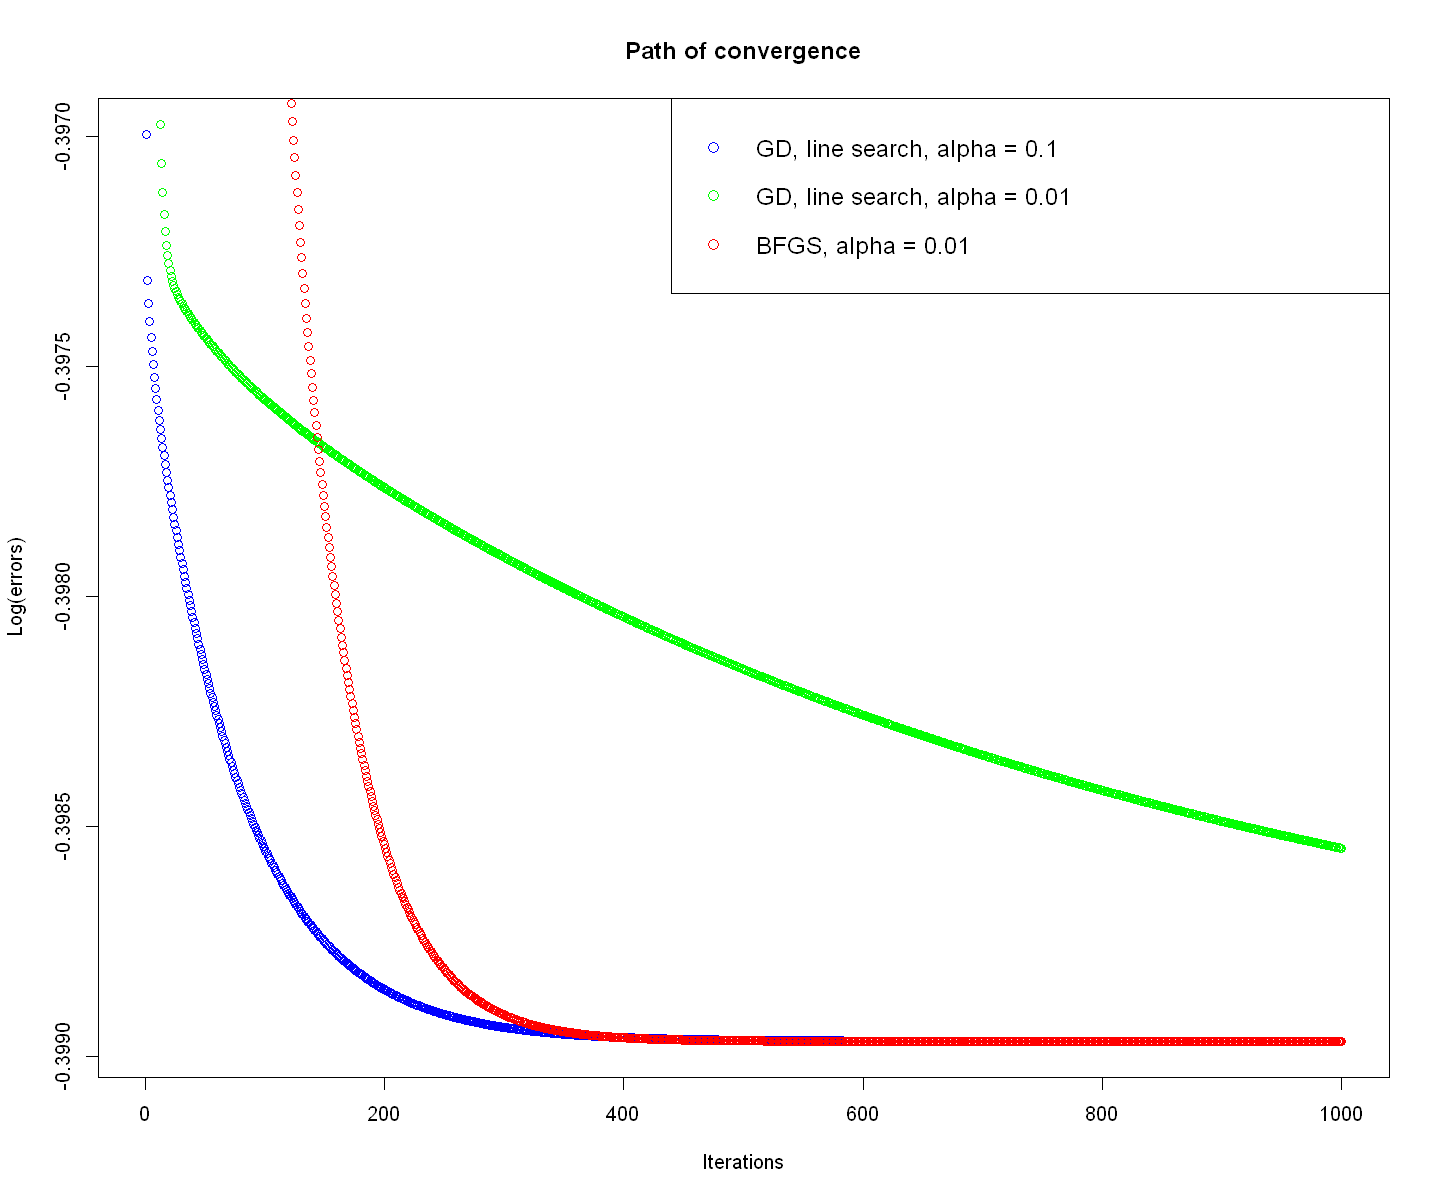

In [37]:
#Visualize the path of convergence.
plot(log(betalist_gd01_ls[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist_gd001_ls[[2]]), col = 'green')
points(log(betalist_bfgs[[2]]), col = 'red')
legend("topright", legend = c("GD, line search, alpha = 0.1", "GD, line search, alpha = 0.01", "BFGS, alpha = 0.01"),
       col = c("blue", "green", "red"), bty = "o", pch = 1, cex = 1.2)

Compared with the logit model, gradient descent for probit suffers more from numeric overflow or underflow due to the way R computes the standard normal densities (easy to get $1$ or $0$). Consequently, a learning rate of $0.1$ appears to be large enough for the algorithm to diverge. We have to use a small $\alpha_t = 0.01$ to ensure convergence. When we have little prior knowledge about what learning rate to use, line search can still be useful in the probit case.